In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost
import sklearn
import shap
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import os

from skopt.learning import ExtraTreesRegressor as opt_ETR
from scipy.stats import norm

import random
random.seed(1126)
np.random.seed(1126)
import warnings
warnings.filterwarnings("ignore")

In [17]:
def crossvalid(xx, yy, model, cvf):
    err_trn = []
    err_tes = []
    r_2_tes = []
    r_2_trn = []
    for train_index, test_index in cvf.split(xx):
        x_trn = pd.DataFrame(np.array(xx)[train_index], columns =xx.columns)
        x_tes = pd.DataFrame(np.array(xx)[test_index], columns = xx.columns)
        y_trn = np.array(yy)[train_index]
        y_tes = np.array(yy)[test_index]
        model.fit(x_trn,y_trn)
        x_trn_pred = model.predict(x_trn)
        x_tes_pred = model.predict(x_tes)


        err_tes.append(mean_squared_error(x_tes_pred, y_tes))
        err_trn.append(mean_squared_error(x_trn_pred, y_trn))
        r_2_tes.append(r2_score(y_tes, x_tes_pred))
        r_2_trn.append(r2_score(y_trn, x_trn_pred))
    v_tes = np.sqrt(np.array(err_tes))
    v_trn = np.sqrt(np.array(err_trn))
    print ("RMSE %1.3f (sd: %1.3f, min:%1.3f, max:%1.3f, det:%1.3f) ... train" % (v_trn.mean(), v_trn.std(),v_trn.min(), v_trn.max(),np.array(r_2_trn).mean()))
    print ("RMSE %1.3f (sd: %1.3f, min:%1.3f, max:%1.3f, det:%1.3f) ... test" % (v_tes.mean(), v_tes.std(), v_tes.min(), v_tes.max(), np.array(r_2_tes).mean()))
    ret = {}
    ret['trn_mean'] = v_trn.mean()
    ret['trn_std'] = v_trn.std()
    ret['trn_r2'] = np.array(r_2_trn).mean()
    ret['tes_mean'] = v_tes.mean()
    ret['tes_std'] = v_tes.std()
    ret['tes_r2'] = np.array(r_2_tes).mean()
    return ret, v_tes.mean()

def plot_importance(model, labels, topk):
    plt.figure(figsize =(6,6))
    importances = model.feature_importances_
    indices = np.argsort(importances)
    topk_idx = indices[-topk:]
    plt.barh(range(len(topk_idx)), importances[topk_idx], color = 'blue', align = 'center')
    plt.yticks(range(len(topk_idx)), labels[topk_idx])
    plt.ylim([-1, len(topk_idx)])
    plt.xlabel("Feature Importance")
    

def one_shot_plot(feat, target, model, xylim = [0,35],  random_state =1126):
    plt.figure()
    plt.subplot().set_aspect('equal')
    x_train, x_test, y_train, y_test = train_test_split(feat, target, test_size= 0.1, random_state = random_state)
    model.fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    plt.plot(y_test, y_test_pred, 'o', c = 'red', markersize = 3,alpha = 0.4, label = 'test')
    plt.plot(y_train, y_train_pred, 'o', c = 'blue', markersize = 3, alpha= 0.4,label = 'train')

    plt.plot([-100,200],[-100,200], c='0', ls ='-', lw = 1.0)
    plt.xlim(xylim)
    plt.ylim(xylim)
    plt.xlabel("Experimental {} [%]".format(target.name))
    plt.ylabel("Predicted {} [%]".format(target.name))
    
def smac(model, init_x, init_y, roen_func, desc, random_state = 1126):
    """
    SMAC　のメインプログラム
    """
    model.fit(init_x.loc[:, with_swed2], init_y)
    print(model)
    mu, sigma =  posterior(init_x.loc[:, with_swed2], init_x.loc[:, with_swed2], init_y, model)
    ei =  EI(mu, sigma, init_y.max())
    ei = pd.Series(ei, index = init_x.index, name = 'ei')
    make_nei =pd.Series(True, index=init_x.index, name='make_nei')
    next_x = pd.concat([init_x, ei, make_nei], axis =1)
    while next_x['make_nei'].sum() != 0:
        next_x = roen_func(next_x, init_y, model, desc)
        print(next_x['make_nei'].sum())
        
    return next_x

def posterior(x, p_x, p_y, model):
    """
    EIを計算する上でのμならびにσの計算(鈴木氏作成)
    """
    if len(p_x.shape) == 1:
        model.fit(p_x.reshape(-1, 1), p_y)
        mu, sigma = model.predict(x.reshape(-1, 1), return_std = True)
    else:
        model.fit(p_x, p_y)
        mu, sigma = model.predict(x, return_std = True)
    ind = np.where(sigma == 0)
    sigma[ind] = 1e-5
    return mu, sigma

def EI(mu, sigma, cur_max):
    """
    EIの計算(鈴木氏作成)
    """
    Z = (mu - cur_max)/ sigma
    ei = (mu - cur_max) * norm.cdf(Z) + sigma*norm.pdf(Z)
    return ei

def opt_function(x, y ,model, desc,random_state =1126):
    """
    各実験ずみの点に対して4回近傍の探索を行い最もEIの高かった組成実験条件を返す
    """
    xx = x.iloc[:,:-2]
    neighbor = pd.DataFrame(index = x.columns)
    for key, row in xx.iterrows():
        count = 0
        nei_cand = []
        #print('ind={0}'.format(key))
        if x.loc[key, 'make_nei'] == True:

            for _ in range(30):
                row_ch = row.copy()
                
                row_ch = SWED_change(row_ch, desc)

                nei_cand.append(row_ch)
                
            for _ in range(30):
                row_ch = row.copy()
                
                row_ch = experiment_change(row_ch)
                
                nei_cand.append(row_ch)
                
            for _ in range(30):
                row_ch = row.copy()
                
                row_ch = SWED_change(row_ch, desc)
                
                row_ch = experiment_change(row_ch)
                
                nei_cand.append(row_ch)
                   

            nei_cand = pd.DataFrame(nei_cand, index =np.arange(len(nei_cand))).fillna(0)
            swed = comp_times_base(nei_cand.loc[:,element],desc.loc[element].T,sort=True,times=True)
            swed = pd.DataFrame(swed)
            swed = swed.iloc[:, :12].fillna(0)
            swed.columns = name2
            nei_cand.loc[:, name2] =swed
                        
            mu, sigma = model.predict(np.array(nei_cand.loc[:, with_swed2]), return_std=True)
            ind = y.values.argmax()
            cur_max = y.iloc[ind]
            ei = EI(mu, sigma, cur_max)
            ind = np.argmax(ei)
            cand = nei_cand.iloc[ind].copy()
            cand['ei'] = ei[ind]
            if x.loc[key, 'ei'] < cand['ei']:
                cand['make_nei'] = True
                neighbor = pd.concat([neighbor, cand], axis = 1)
            else:
                x.loc[key, 'make_nei'] = False
                neighbor = pd.concat([neighbor, x.loc[key,:]], axis = 1)
                
        else:
            neighbor = pd.concat([neighbor, x.loc[key,:]], axis = 1)
                                                    
    print('-----------')
    
    neighbor = neighbor.T
    neighbor.index = x.index
    return neighbor



def SWED_change(row_ch, desc):
    row_ch[element] = 0

    for i in range(1, 4):
        #i-1回目の処理のデータを保存
        row_sub = row_ch
        x_ch =data

        #大きい方からchange_f番目の元素に紐ずくaddtional descriptorを一括での局所的探索
        change_col= list([f"{i+1}_electronegativity", f"{i+1}_delta_fus H",f"{i+1}_density"])
        a = row_ch[change_col] - x_ch[change_col].min()
        b = x_ch[change_col].max() - x_ch[change_col].min()
        v = a/b

        v = np.minimum(v, 1.0)

        p = np.array([-1])
        count = 0
        while (p <0).any() | (p>1).any():
            p = random.normalvariate(v, 0.1)
            count += 1
            if (count % 1000) == 0:
                print("count:", count)

        p = p * b + x_ch[change_col].min()
        row_ch[change_col] = p
        p = np.array(p)
        
        #alpha = x1_x0/x1_2#２次関数の軸の位置
        alpha = desc.apply(lambda u: np.dot(u, p)/np.dot(u, u), axis = 1)
        #εの値が小さい元素名を返す
        epsilon = desc.mul(alpha, axis=0).apply(lambda u: np.dot(u-p, u-p), axis=1).sort_values().index


        for i in range(0, len(epsilon)):
            #軸が100以下をみたし、　組成元素が0ではない元素に変換する
            if (alpha[epsilon[i]] < 100) & (row_ch[epsilon[i]] == 0):
                row_ch[epsilon[i]] = alpha[epsilon[i]]
                break

        #組成の合計が100を超えると処理を抜ける        
        if row_ch[element].sum() >= 100:
            break

    # 100によりちかい組成を選択肢、標準化
    if  abs(100 -row_ch[element].sum()) > abs(100-row_sub[element].sum()):
        row_ch[element] =  (row_sub[element] * 100) / row_sub[element].sum()

    else:
        row_ch[element] =  (row_ch[element] * 100) / row_ch[element].sum()
    
    return row_ch

def experiment_change(row_ch):
    cols =list(preparation) + list(experiment)
    x_ch = data
    
    change_f = random.choice(cols)
    
    if change_f in experiment:
        a = np.array(row_ch[change_f]) - x_ch[change_f].min()
        b = x_ch[change_f].max() - x_ch[change_f].min()
        v = a / b
        p = -1
        while (p < 0) | (p > 1):
            p = random.normalvariate(v, 0.1)

        p = p * b + x_ch[change_f].min()
        row_ch[change_f] = p

    elif change_f in preparation:
        row_ch[change_f] = 1
        ind = set(preparation) - {change_f}
        row_ch[ind] = 0
        
    return row_ch


In [18]:
data = pd.read_excel("data/WGS.xlsx", skiprows = 8)
drop_cols = ["ZEO", "HAP", "ACC", "YSZ"]
idx = (data.loc[:, drop_cols] == 0).all(axis =1)
data = data[idx].drop(drop_cols, axis = 1)
data.index = np.arange(len(data))

base_metal = data.loc[:,"Pt":"Pd"].columns
preparation = data.loc[:,"IWI":"DP"].columns
cal_cond = data.loc[:,"Calcination Temperture (℃)":"Calc T. (hr)"].columns
support = data.loc[:,"Al2O3":"CaO"].columns
promoter= data.loc[:,"Li":"Sr"].columns
exp_cond = data.loc[:,"Reaction Temperture (℃)":"F/W (mg.min/ml)"].columns
element =  list(base_metal)  +list(support) + list(promoter)
experiment =  list(cal_cond) + list(exp_cond)

desc = pd.read_csv("data/Descriptors_WGS.csv", skiprows=[0], index_col="symbol")
desc.drop(
    [
        "Unnamed: 0",
        "AN",
        "name",
        "period",
        "ionic radius",
        "covalent radius",
        "group",
        "VdW radius",
        "crystal radius",
        "a x 106 ",
        "Heat capacity ",
        "l",
        "electron affinity ",
        "VE",
        "Surface energy ",
    ],
    axis=1,
    inplace=True,
)
desc = desc.fillna(desc.mean())

sub =100 - data.loc[:, base_metal].sum(axis = 1) - data.loc[:, promoter].sum(axis = 1)
data.loc[:, support] = pd.DataFrame(np.array(data.loc[:, support]) *np.array(sub).reshape(-1, 1), columns = support)
support_data = pd.read_excel("data/support.xlsx", index_col = 0)

data.loc[:, support] = data.loc[:,  support]/  support_data.loc[:, "ave_MW"].T
data.loc[:, base_metal] = data.loc[:, list(base_metal)]/desc.loc[list(base_metal) , "AW"].T
data.loc[:, promoter] = data.loc[:, list(promoter)]/desc.loc[list(promoter),  "AW"].T
data.loc[:, element]  =  pd.DataFrame(np.array(data.loc[:, element])/np.array(data.loc[:, element].sum(axis = 1)).reshape(-1,1),
                                      columns = element)*100

for i in support_data.index:
    key =  support_data.loc[i, "key"]
    if key in promoter:
        data.loc[:, key] = data.loc[:, key] + data.loc[:, i]
        
    else:
        data.loc[:, key] =  data.loc[:, i]
        
element =list(base_metal)+ list(promoter)+ ["Al", "Tb", "Hf", "Th", "Si"] 
conventional =  list(base_metal) + list(preparation) + list(cal_cond) + list(promoter)+ ["Al", "Tb", "Hf", "Th", "Si"] + list(exp_cond)

def comp_times_base(comp, base, sort=False, times=True, attention=False):
    count = 0
    for key, rows in comp.iterrows():
        stack = np.vstack((rows, base))
        if times == True:
            time = np.array(base) * np.array(rows)
            stack = np.vstack((rows, time))

        if sort == True:
            stack = pd.DataFrame(stack).sort_values(
                [0], ascending=False, axis=1)

        stack = pd.DataFrame(stack).iloc[1:, :]
        stack = np.array(stack)

        if count == 0:
            if attention:
                res = np.sum(stack, axis=1)
            else:
                res = np.array(stack.T.flatten())

            count += 1
        else:
            if attention:
                res = np.vstack((res, np.sum(stack, axis=1)))
            else:
                res = np.vstack((res, np.array(stack.T.flatten())))

            count += 1
    return res
name = []
for i in range(1, 5):
    #name.append('%i_AN'%i)
    name.append('%i_AW'%i)
    #name.append('%i_group'%i)
    #name.append('%i_period'%i)
    name.append('%i_atomic radius'%i)
    name.append('%i_electronegativity'%i)
    name.append('%i_m. p.'%i)
    name.append('%i_b. p.'%i)
    name.append('%i_delta_fus H'%i)
    name.append('%i_density'%i)
    name.append('%i_ionization enegy'%i)
    
name2 = []
for i in range(1, 5):
    #name2.append('%i_AN'%i)
    #name2.append('%i_AW'%i)
    #name2.append('%i_group'%i)
    #name2.append('%i_period'%i)
    #name2.append('%i_atomic radius'%i)
    name2.append('%i_electronegativity'%i)
    #name2.append('%i_m. p.'%i)
    #name2.append('%i_b. p.'%i)
    name2.append('%i_delta_fus H'%i)
    name2.append('%i_density'%i)
    #name2.append('%i_ionization enegy'%i)
    

swed =pd.DataFrame(comp_times_base(data.loc[:, element], desc.loc[element].T, sort = True)).iloc[:, :32]
swed.columns = name
data = pd.concat([data, swed], axis= 1)

with_swed = name  + list(preparation) + list(cal_cond) + list(exp_cond)
with_swed2 = name2 + list(preparation) + list(cal_cond) + list(exp_cond)
smac_swed = element +name2 + list(preparation) + list(cal_cond) + list(exp_cond)

data.head()

,Total # of Data,Reference,Data,Pt,Au,Ru,Rh,Ir,Cu,Pd,...,3_density,3_ionization enegy,4_AW,4_atomic radius,4_electronegativity,4_m. p.,4_b. p.,4_delta_fus H,4_density,4_ionization enegy
0,1,Andreeva et al.[S1],1,0.0,0.879971,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,NaN,2,0.0,2.646330,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,NaN,3,0.0,4.421297,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,NaN,4,0.0,0.879971,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,NaN,5,0.0,2.646330,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Concentional Model

ETR
RMSE 2.737 (sd: 0.080, min:2.602, max:2.882, det:0.993) ... train
RMSE 10.640 (sd: 0.921, min:8.912, max:11.970, det:0.891) ... test
XGB
[12:56:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:57:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:57:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:57:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:57:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:58:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:58:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:58:29] WARNING: src/objective/regression_ob

({'trn_mean': 13.083436946657695,
  'trn_std': 0.10810931678518344,
  'trn_r2': 0.8369949568407321,
  'tes_mean': 14.614732644797758,
  'tes_std': 0.8279385461212613,
  'tes_r2': 0.7951357195642914},
 14.614732644797758)

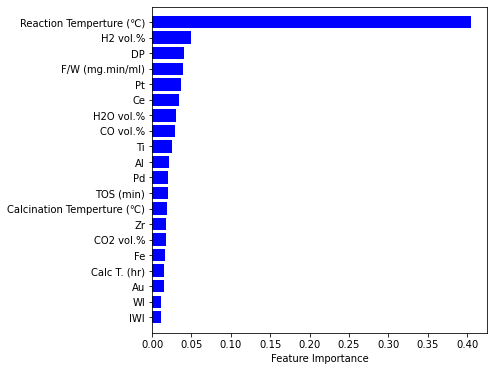

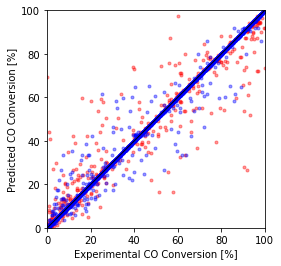

In [44]:
folder = "conventional"
feat = data.loc[:, columns]
target =data.loc[:,  'CO Conversion']
path = "out/" + folder + "/"

os.makedirs(path, exist_ok = True)
cvf = KFold(n_splits = 10, shuffle = True)

print("ETR")
cvmodel = GridSearchCV(ExtraTreesRegressor(n_jobs = -1, random_state = 1126),
                      param_grid = {"n_estimators": [250, 500, 1000]}, n_jobs = -1)
crossvalid(feat, target, cvmodel, cvf)

cvmodel.fit(feat, target)
model = cvmodel.best_estimator_

plot_importance(model, feat.columns, 20)
plt.savefig(path + "importance_ETR.png", bbox_inches = "tight", dpi = 300)

one_shot_plot(feat, target, model, xylim = [0, 100],  random_state =1126)
plt.savefig(path + "one_shot_ETR.png", bbox_inches = "tight", dpi = 300)

print("XGB")
cvmodel = GridSearchCV(XGBRegressor(n_jobs = -1, random_state = 1126),
                      param_grid = {"n_estimators": [250, 500, 1000]}, n_jobs = -1)
crossvalid(feat, target, cvmodel, cvf)

### with SWED

ETR
RMSE 2.749 (sd: 0.071, min:2.640, max:2.871, det:0.993) ... train
RMSE 10.491 (sd: 0.916, min:9.276, max:11.802, det:0.894) ... test
XGB
[13:25:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:25:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:25:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:25:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:26:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:26:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:26:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:26:50] WARNING: src/objective/regression_ob

({'trn_mean': 12.297637554350136,
  'trn_std': 0.08700896134188965,
  'trn_r2': 0.8559952519322603,
  'tes_mean': 13.926143757139362,
  'tes_std': 0.842432902275965,
  'tes_r2': 0.8143224658144114},
 13.926143757139362)

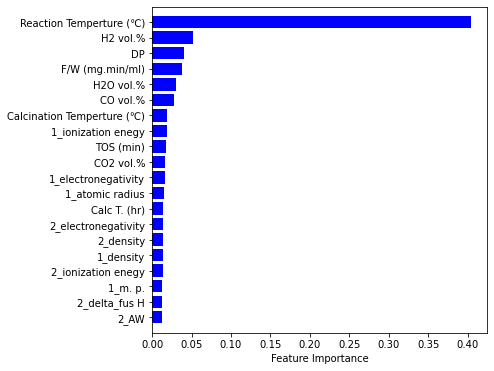

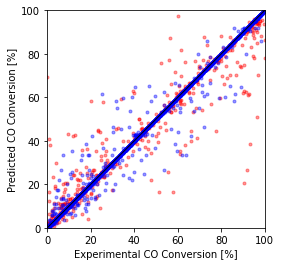

In [49]:
folder = "with_swed"
feat = data.loc[:, with_swed]
target =data.loc[:,  'CO Conversion']
path = "out/" + folder + "/"

os.makedirs(path, exist_ok = True)
cvf = KFold(n_splits = 10, shuffle = True)

print("ETR")
cvmodel = GridSearchCV(ExtraTreesRegressor(n_jobs = -1, random_state = 1126),
                      param_grid = {"n_estimators": [250, 500, 1000]}, n_jobs = -1)
crossvalid(feat, target, cvmodel, cvf)

cvmodel.fit(feat, target)
model = cvmodel.best_estimator_

plot_importance(model, feat.columns, 20)
plt.savefig(path + "importance_ETR.png", bbox_inches = "tight", dpi = 300)

one_shot_plot(feat, target, model, xylim = [0, 100],  random_state =1126)
plt.savefig(path + "one_shot_ETR.png", bbox_inches = "tight", dpi = 300)

print("XGB")
cvmodel = GridSearchCV(XGBRegressor(n_jobs = -1, random_state = 1126),
                      param_grid = {"n_estimators": [250, 500, 1000]}, n_jobs = -1)
crossvalid(feat, target, cvmodel, cvf)

### with SWED (3 descriptors)

ETR
RMSE 2.755 (sd: 0.078, min:2.647, max:2.897, det:0.993) ... train
RMSE 11.183 (sd: 0.437, min:10.487, max:11.795, det:0.881) ... test
XGB
[13:51:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:51:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:51:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:51:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:52:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:52:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:52:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:52:27] WARNING: src/objective/regression_o

({'trn_mean': 12.626715899149634,
  'trn_std': 0.1547245348009227,
  'trn_r2': 0.8481705044450798,
  'tes_mean': 14.264812463532461,
  'tes_std': 0.3996411648934776,
  'tes_r2': 0.8056675334777003},
 14.264812463532461)

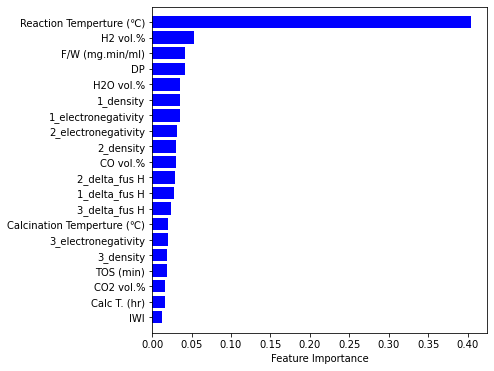

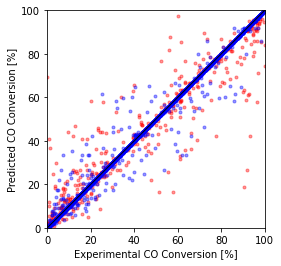

In [52]:
folder = "with_swed2"
feat = data.loc[:, with_swed2]
target =data.loc[:,  'CO Conversion']
path = "out/" + folder + "/"

os.makedirs(path, exist_ok = True)
cvf = KFold(n_splits = 10, shuffle = True)

print("ETR")
cvmodel = GridSearchCV(ExtraTreesRegressor(n_jobs = -1, random_state = 1126),
                      param_grid = {"n_estimators": [250, 500, 1000]}, n_jobs = -1)
crossvalid(feat, target, cvmodel, cvf)

cvmodel.fit(feat, target)
model = cvmodel.best_estimator_

plot_importance(model, feat.columns, 20)
plt.savefig(path + "importance_ETR.png", bbox_inches = "tight", dpi = 300)

one_shot_plot(feat, target, model, xylim = [0, 100],  random_state =1126)
plt.savefig(path + "one_shot_ETR.png", bbox_inches = "tight", dpi = 300)

print("XGB")
cvmodel = GridSearchCV(XGBRegressor(n_jobs = -1, random_state = 1126),
                      param_grid = {"n_estimators": [250, 500, 1000]}, n_jobs = -1)
crossvalid(feat, target, cvmodel, cvf)

[14:02:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


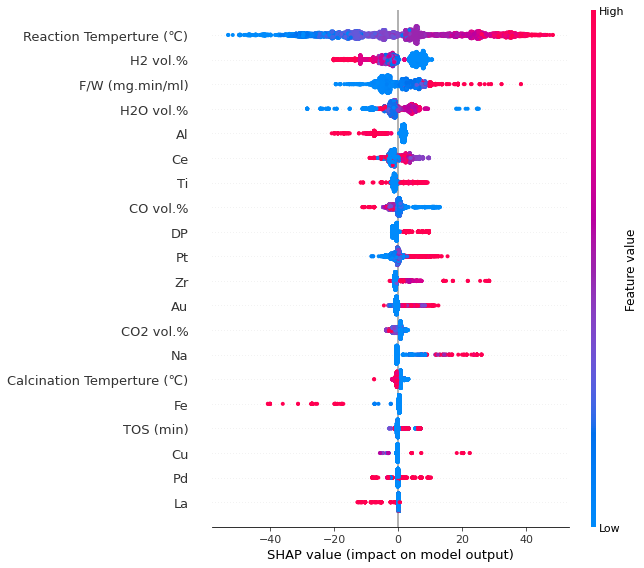

In [4]:
folder = "conventional"
feat = data.loc[:, conventional]
target =data.loc[:,  'CO Conversion']
path = "out/" + folder + "/"

cvmodel = GridSearchCV(XGBRegressor(n_jobs = -1, random_state = 1126),
                      param_grid = {"n_estimators": [250, 500, 1000]}, n_jobs = -1)

cvmodel.fit(feat, target)

model = cvmodel.best_estimator_
explainer = shap.TreeExplainer(model=model)
shap_values = explainer.shap_values(feat) 

shap.summary_plot(shap_values, feat, show = False)
plt.savefig("out/conventional/shap.png", format = "png", dpi = 600, bbox_inches = 'tight')

In [4]:
shap.initjs()
#shap.force_plot(base_value=explainer.expected_value, shap_values=shap_values, features=feat)

In [19]:
folder = "smac"
idx = data.loc[:, 'Reaction Temperture (℃)'] <= 150
data = data[idx]
feat = data.loc[:, smac_swed]
target =data.loc[:,  'CO Conversion']
path = "out/" + folder + "/"
os.makedirs(path, exist_ok = True)

print(feat.shape)

cvmodel = GridSearchCV(ExtraTreesRegressor(n_jobs = -1, random_state = 1126),
                      param_grid = {"n_estimators": [250, 500, 1000]}, n_jobs = -1)
cvmodel.fit(feat.loc[:, smac_swed], target)
n_tree = cvmodel.best_params_["n_estimators"]

(163, 75)


In [ ]:
%%time
 model = opt_ETR(n_estimators = n_tree, random_state = 1126, n_jobs = -1)
cand = smac(model, feat, target,opt_function, desc.loc[element, ['electronegativity', 'delta_fus H ', 'density']])

ExtraTreesRegressor(n_estimators=1000, n_jobs=-1, random_state=1126)
-----------
163.0
-----------
162.0
-----------
159.0


In [ ]:
from sklearn.cluster import KMeans
feat = feat.loc[:, with_swed2]
model = opt_ETR(n_estimators = 500, n_jobs = -1)
k = KMeans(n_clusters=40, random_state=1126)
cluster = k.fit_predict(cand.iloc[:,:-1])
cluster = pd.Series(cluster, index=cand.index, name='cluster')
cand = pd.concat([cand,cluster], axis=1)
model.fit(feat, target)
pred_y = model.predict(cand.loc[:,with_swed2])
pred_y = pd.Series(pred_y, index = cand.index, name = 'pred_y')
cand = pd.concat([cand,pred_y], axis = 1)
#choose point which has most better ei value in each cluster
clus_high = cand.sort_values(by=['cluster','ei']).drop_duplicates(subset=['cluster'],keep='last')
clus_high = clus_high.sort_values(by='ei', ascending=False)

hogege = []
for key,row in clus_high.loc [:,element].iterrows():
    temp = [str(i)+':'+str(round(v,1)) for i,v in row[row>0].sort_values(ascending=False).iteritems()]
    hogege.append(temp)
    
hogege = [' '.join(x) for x in hogege]

w = 0.4
hoge = clus_high.iloc[:20]
x = np.arange(hoge.shape[0])
pred_y = list(clus_high['pred_y'])
    
                
extra = []
for y in x:
    extra.append(y)
    
ytick = []
for n in range(20):
    ytick.append(hogege[n])
    
plt.figure(figsize=(6,6), dpi=600)
plt.barh(x,hoge['ei'][::-1],label='EI', color = 'blue')
for n,i in enumerate(x[::-1]):
    plt.text(clus_high['ei'].iloc[n],i-0.4,str(round(clus_high['ei'].iloc[n],2)),fontsize=12)


plt.xlim([0,10])
plt.yticks(x[::-1],ytick)
#temp =clus_high.loc[:,"Temperature, K":"ei"]
#temp.index = hogege
#temp.to_csv("Table_3.csv")
plt.savefig('WGS_below150.png', dpi = 600, bbox_inches = 'tight')

In [82]:
cand = cand.iloc[:, :-4]

In [97]:
feat

,Pt,Au,Ru,Rh,Ir,Cu,Pd,Li,Ce,Co,...,Calc T. (hr),Reaction Temperture (℃),H2 vol.%,O2 vol.%,CO vol.%,H2O vol.%,CO2 vol.%,CH4 vol.%,TOS (min),F/W (mg.min/ml)
0,0.000000,0.879971,0.000000,0.0,0.0,0.0,0.0,0.0,99.120029,0.0,...,0.0,140.0,0.0,0.0,4.498,30.6,0.0,0.0,60.0,2.0
1,0.000000,2.646330,0.000000,0.0,0.0,0.0,0.0,0.0,97.353670,0.0,...,0.0,140.0,0.0,0.0,4.498,30.6,0.0,0.0,60.0,2.0
2,0.000000,4.421297,0.000000,0.0,0.0,0.0,0.0,0.0,95.578703,0.0,...,0.0,140.0,0.0,0.0,4.498,30.6,0.0,0.0,60.0,2.0
51,0.888387,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,99.111613,0.0,...,5.0,120.0,0.0,0.0,4.000,2.6,0.0,0.0,60.0,2.0
58,0.000000,0.879971,0.000000,0.0,0.0,0.0,0.0,0.0,99.120029,0.0,...,2.0,120.0,0.0,0.0,4.000,2.6,0.0,0.0,60.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4121,0.000000,0.000000,1.159066,0.0,0.0,0.0,0.0,0.0,80.258590,0.0,...,0.0,106.0,0.0,0.0,1.000,2.0,0.0,0.0,60.0,1.0
4142,0.000000,0.000000,1.455176,0.0,0.0,0.0,0.0,0.0,1.025335,0.0,...,0.0,51.7,0.0,0.0,1.000,2.0,0.0,0.0,60.0,1.0
4143,0.000000,0.000000,1.455176,0.0,0.0,0.0,0.0,0.0,1.025335,0.0,...,0.0,82.9,0.0,0.0,1.000,2.0,0.0,0.0,60.0,1.0
4144,0.000000,0.000000,1.455176,0.0,0.0,0.0,0.0,0.0,1.025335,0.0,...,0.0,133.0,0.0,0.0,1.000,2.0,0.0,0.0,60.0,1.0
